In [1]:
import numpy as np
from implementations import *
from logistic_regression import *
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt

### Load Data

In [2]:
y, x, id = load_csv_data("data/train.csv")
print(x.shape, y.shape)

(250000, 30) (250000,)


### Data Exploration

In [4]:
np.unique(y, return_counts=True)

(array([-1.,  1.]), array([164333,  85667], dtype=int64))

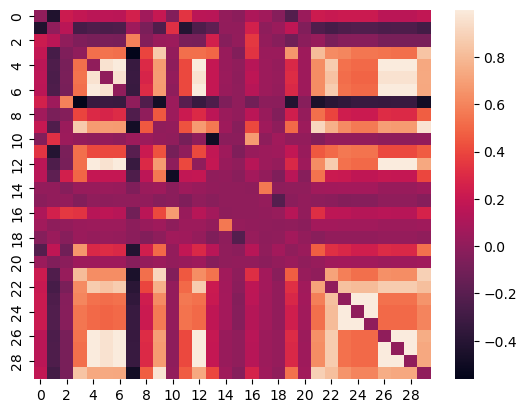

In [5]:
corr = np.zeros((x.shape[1], x.shape[1]))
for i in range(x.shape[1]):
   for j in range(x.shape[1]):
       if i!=j:
           corr[i][j] = np.corrcoef(x = x[:1000, i], y= x[:1000, j])[0, 1]
sns.heatmap(corr);

In [6]:
np.count_nonzero(x == -999, axis = 0) #find the the columns which have undefined values

array([ 38114,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  99913,
        99913,  99913, 177457, 177457, 177457,      0], dtype=int64)

In [3]:
def imputer(data):
    data[data == -999] = np.nan
    col_mean = np.nanmedian(data, axis=0)
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])
    return data
    
# X = imputer(x)
# x.shape

In [56]:
col = []
for i in np.unique(x[:, -8]):
    col.append([1 if t==i else 0 for t in x[:, -8]])
x = np.delete(x, 22, axis = 1)

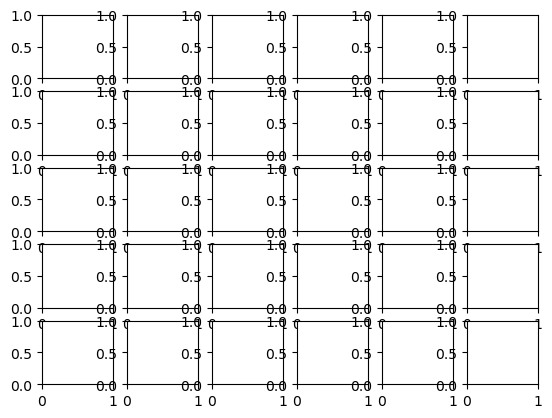

In [27]:
fig, axs = plt.subplots(nrows=5, ncols=6)

# for ax in axs.reshape(-1): 
#   print(i)
#   ax.hist(x[:, i])
#   plt.show()
# for i in range(x.shape[1]):
#     print(i)
#     plt.hist(x[:, i])
#     plt.show()

We should use Log Transform to convert a skewed distribution to a less-skewed distribution.

https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/

In [4]:
positive_cols = [0,1,2,3,4,5,7,8,9,10,12,13,16,19,21,23,26]
x_log_transform = np.log(1 / (1 + X[:, positive_cols])) # x[:, positive_cols])
X = np.hstack([X, x_log_transform])

In [4]:
def build_poly(poly, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.
    """
    for i in range(poly.shape[1]):
        for j in range(2, degree + 1):
            poly = np.concatenate((poly, np.array(poly[:, i]**j).reshape(poly.shape[0], 1)), axis=1)
    return poly

# X = build_poly(X, 2)

In [6]:
X = standardize(X)[0]
# X = np.concatenate((X, np.array(col).reshape(len(col[-1]), 4)), axis = 1)


In [7]:
x_train, x_test, y_train, y_test = split_data(X, y, 0.80)
# w_class0 = np.where(y_train == -1)[0]
# w_class1 = np.where(y_train == 1)[0]
# w_class0_downsampled = np.random.choice(w_class0, size=int(w_class1.shape[0]), replace=True)
# y_train = np.hstack((y_train[w_class1], y_train[w_class0_downsampled]))
# x_train = np.vstack((x_train[w_class1], x_train[w_class0_downsampled]))

In [43]:
# np.unique(y_train, return_counts=True)

(array([0., 1.]), array([68437, 68437], dtype=int64))

In [9]:
tr = Logistic_Regression(8000, 0.61, [x_train, y_train], [x_test, y_test], id) # 0.777
tr.train()
print(tr.train_accuracy)
tr.test()

d:\VSC_projects\ML_Higgs\logistic_regression.py:46: RuntimeWarning: divide by zero encountered in log
  return np.sum(-(1 / y.shape[0]) * (y.T.dot(np.log(self.sigmoid(tx.dot(w))))+ (1 - y).T.dot(np.log(1 - self.sigmoid(tx.dot(w))))))


0.779005
0.77744


In [7]:
# To sum up preprosessing
def prepresessing(x, degree):
    x = imputer(x)
    positive_cols = [0,1,2,3,4,5,7,8,9,10,12,13,16,19,21,23,26]
    x_log_transform = np.log(1 / (1 + x[:, positive_cols])) # x[:, positive_cols])
    x = np.hstack([x, x_log_transform])
    x = build_poly(x, degree)
    x = standardize(x)[0]
    return x

### Cross Validation

In [27]:
from math import degrees


def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


def cross_validation(degrees, k_fold, lambdas):
    """cross validation over regularisation parameter lambda.
    """
    seed = 12
    degrees = degrees
    k_fold = k_fold
    lambdas = lambdas
    k_indices = build_k_indices(y, k_fold, seed)
    rmse_tr = []
    rmse_te = []
    lambdas_array = []
    # n = 0
    gamma = []

    for lambda_ in lambdas:
        # print(n)
        for g in degrees:
            trl, tel = [], []
            for i in range(k_fold):
                ind = np.concatenate((k_indices[:i], k_indices[i+1:])).flatten()
                x_test = x[k_indices[i]]
                x_train = x[ind]
                y_test = y[k_indices[i]]
                y_train = y[ind]
                x_train = prepresessing(x_train, 2)
                x_test = prepresessing(x_test, 2)
                
                tr = Reg_Logistic_Regression(200, lambda_, g, [x_train, y_train], [x_test, y_test], id)
                tr.train()
                tr.test()
                
                trl.append(tr.train_accuracy)
                tel.append(tr.test_accuracy)
            rmse_tr.append(np.mean(trl))
            gamma.append(g)
            lambdas_array.append(lambda_)
            rmse_te.append(np.mean(tel))
        # n+=1
    best_rmse = np.max(rmse_te)
    best_lambda = lambdas_array[np.argmax(rmse_te)]
    best_degree = gamma[np.argmax(rmse_te)]
    cross_validation_visualization(lambdas_array, rmse_tr, rmse_te)
    print("For polynomial expansion up to degree %.f, the choice of lambda which leads to the best test rmse is %.5f with a test rmse of %.3f" % (best_degree, best_lambda, best_rmse))
    return best_lambda, best_rmse, best_degree

best_lambda, best_rmse, best_degree = cross_validation(np.logspace(-10, -1, 10), 4, np.logspace(-10, 0, 10))